# Time Series Analysis

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


Populating the interactive namespace from numpy and matplotlib


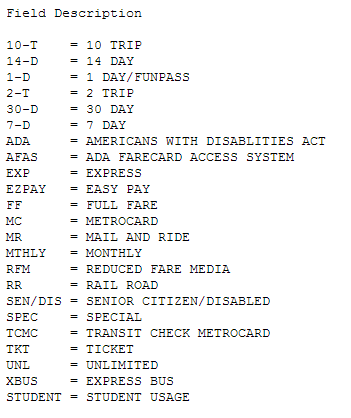

In [1]:
# import packages and functions 
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
import statsmodels.formula.api as smf

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

## read in the data 

In [2]:
# read in the data 
mta = np.load("MTA_Fare.npy")

In [3]:
# check the shape of the data
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [4]:
# ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [5]:
# convert -1 values to nans
mta = mta.astype('float')
mta[mta == -1] = np.nan

In [6]:
# create a daterange for plotting 
dates = pd.date_range(start='05/19/2010', periods=194, freq='W')

You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

Text(0.5,0.98,'Figure 1: Time Series for all Card Types and All Stations in NYC in Natural and Log space')

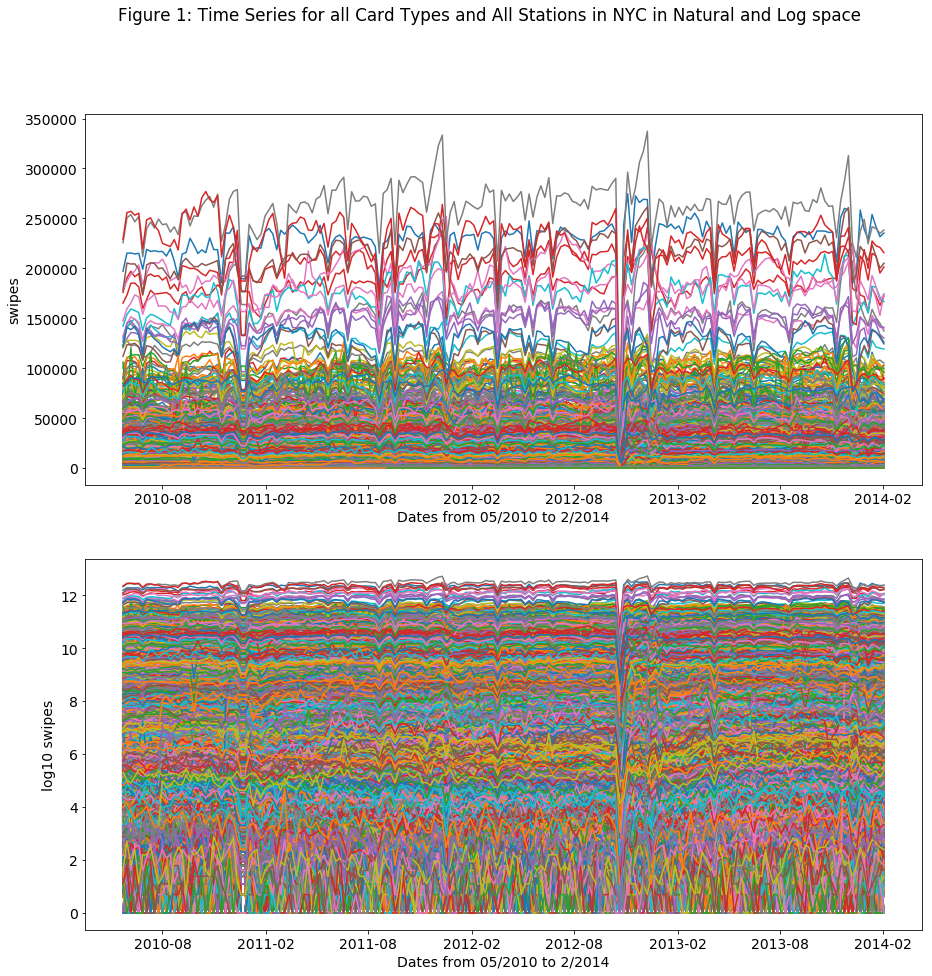

In [7]:
# plot the data in natural and log space  
# this code came from Ursula 

plt.rcParams.update({'font.size':14})
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
ax1.set(xlabel='Dates from 05/2010 to 2/2014', ylabel='swipes')
for i in range(len(mta)):
    for j in range(len(mta[i])):
        ax1.plot(dates, mta[i][j])
ax2.set(xlabel='Dates from 05/2010 to 2/2014', ylabel='log10 swipes')
for i in range(len(mta)):
    for j in range(len(mta[i])):
        ax2.plot(dates, np.log(mta[i][j]))
plt.suptitle('Figure 1: Time Series for all Card Types and All Stations in NYC in Natural and Log space')       

**Figure 1**: Time Series of swipes for all Card Types and All Stations in NYC in Natural and Log space. The top plot is the time series in natual space. There is a lot of variability in the number of swipes per card type - some card types have a high number of swipes and some have a very low number of swipes. There appears to be some periodicity in the time series. There is a large drop in swipes for all card types between 8/12 and 02/13. The bottom plot is the time series in log10 space. I converted to log space because swipes are distributed unevenly between the card types. The plot is more attractive to visualize when the y axis is in log space. In the log plot it's clear that there is a drop in the number of swipes for all card types between 8/12 and 02/13.

# Part 1: Event Detection 

In [8]:
# calculate total swipes, mean, and stdev 
weekly_sum = np.nansum(np.nansum(mta, axis=0), axis=0)
weekly_mean = weekly_sum.mean()
weekly_stdev = weekly_sum.std()
three_sigma = weekly_mean - (3 * weekly_stdev)
print("mean number of swipes per week:", int(weekly_mean))
print("standard deviation of swipes per week:", int(weekly_stdev))
print("3-sigma drop threshold:", int(three_sigma))

mean number of swipes per week: 29781349
standard deviation of swipes per week: 2983960
3-sigma drop threshold: 20829468


In [9]:
# isolate the date of the three sigma drop 
event = np.where(weekly_sum < three_sigma)
dates[event[0][0]+1]

Timestamp('2012-10-28 00:00:00', offset='W-SUN')

**Discussion**: The date of the three sigma drop in all time series was 10/28/2012 which is when Hurricane Sandy occurred. Hurricane Sandy disrupted subways throughout the city so it makes sense that swipes dipped (>3 sigma) for all time series on this date. 

# Part 2: Finding Trends

In [10]:
# define a function to take the card type as an argument and plot its rolling mean 
def plot_card(card_type, dates):
    '''
    function takes the argument card type and plots its rolling mean over the weeks specified in the date argument
    '''
    plt.style.use('seaborn-ticks')
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set(xlabel = 'Dates', ylabel = 'Swipes per Card Type')
    ax.plot(dates, card_type[type_key])

In [11]:
# take the mean for each card type and each week 
card_mean = np.nanmean(mta, axis=0)
# convert to a df with card type as columns and week as rows 
card_df = pd.DataFrame(card_mean).T
card_df.columns = list(ridetype)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


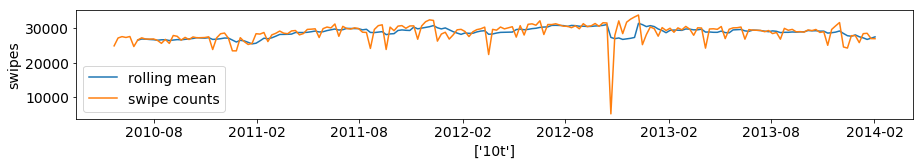

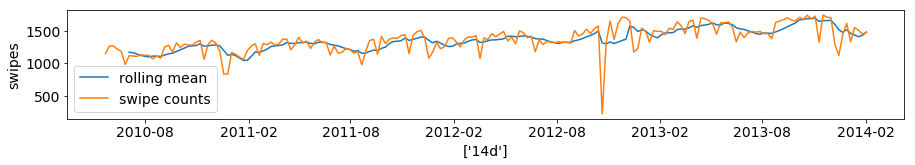

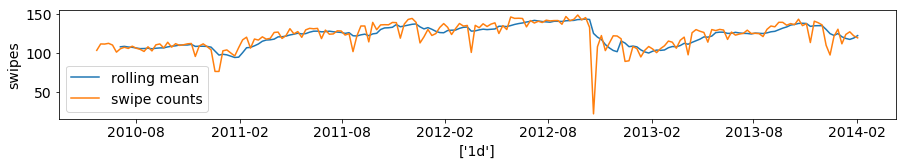

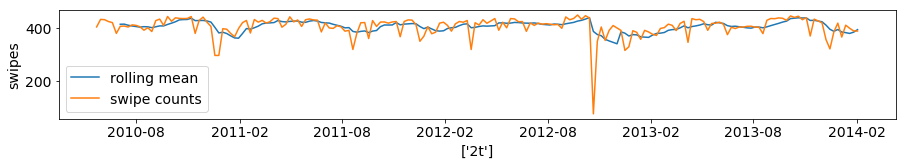

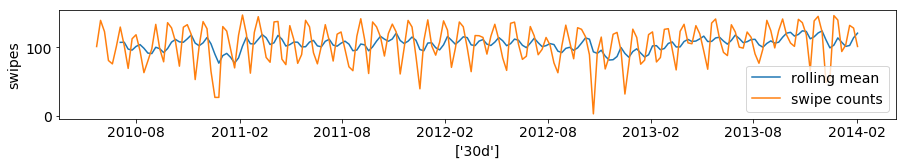

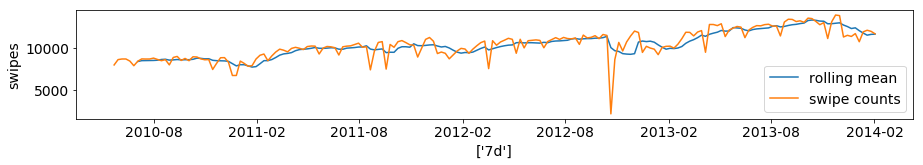

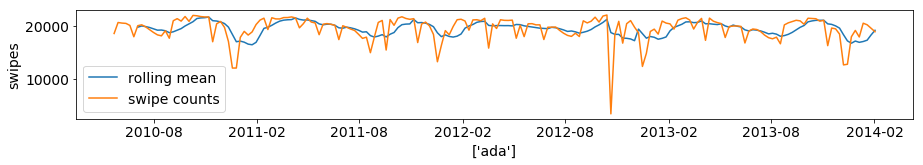

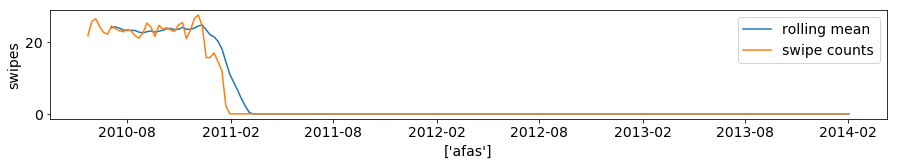

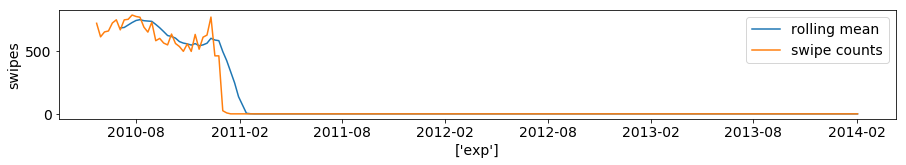

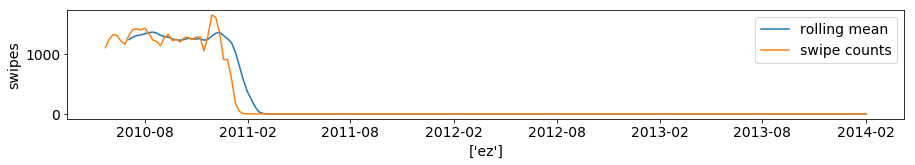

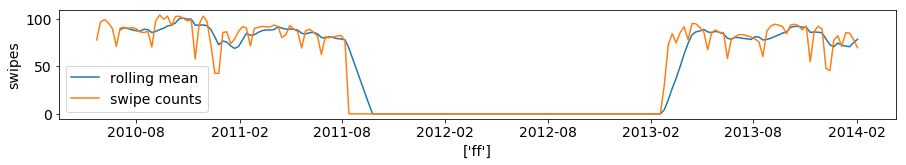

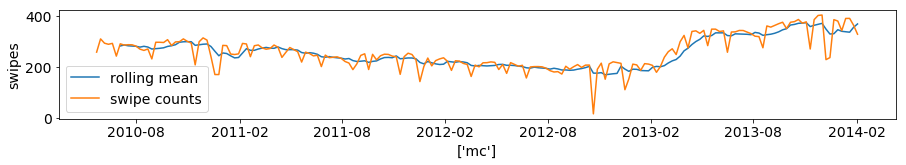

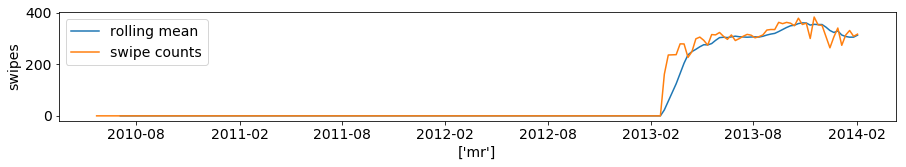

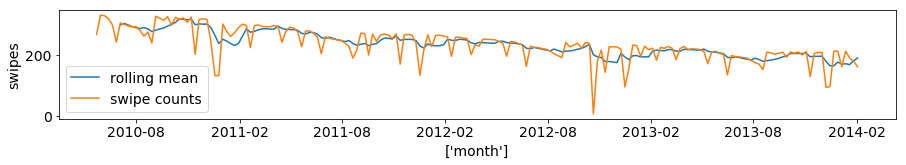

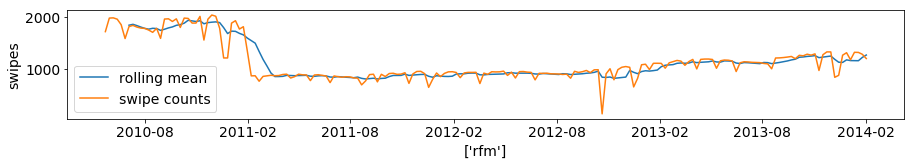

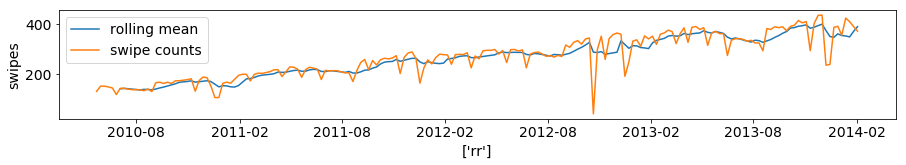

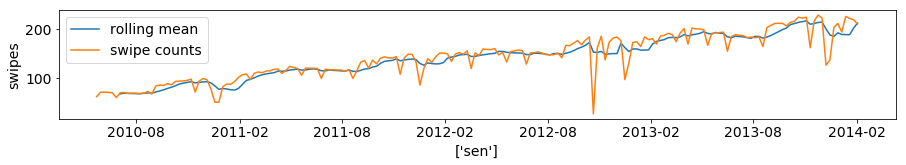

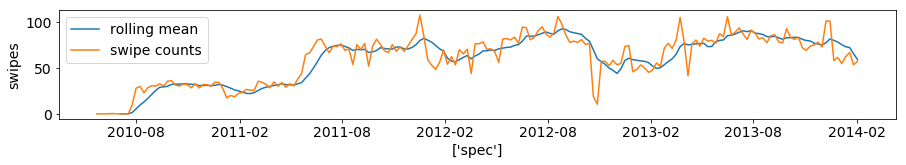

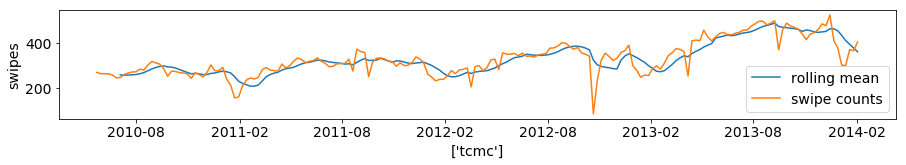

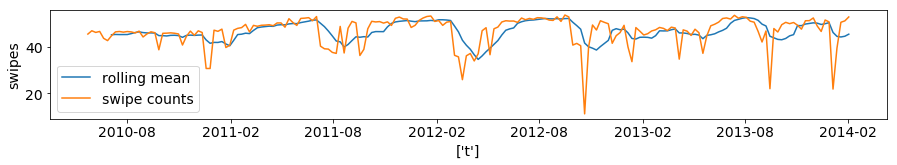

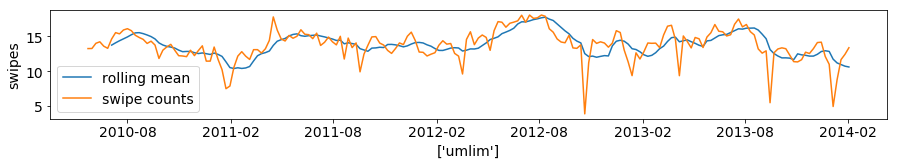

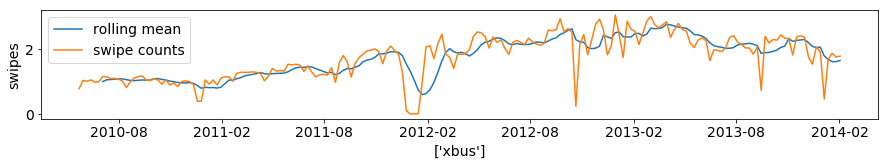

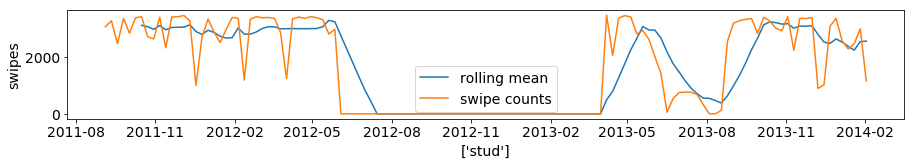

In [12]:
# plot the time series for each card type individually for inspection 
# Ursula wrote this code 
plt.rcParams.update({'figure.max_open_warning': 0})
card_rmean = pd.DataFrame()
for type in ridetype:
    fig = plt.figure(figsize = (15,2))
    ax = fig.add_subplot(111)
    card_rmean[type] = card_df[type].rolling(7).mean()
    ax.plot(dates, card_rmean[type], label = 'rolling mean')
    ax.plot(dates, card_df[type], label = 'swipe counts')
    cols = ['{}'.format(type)]
    ax.set(xlabel = cols, ylabel = 'swipes')
    plt.legend()

**Figure 2**: Time Series of swipes for each card type in NYC in natural space. Each plot contains a time series of swipe counts as well as a time series of the rolling mean. By looking at the plots, I can identify which card types have smooth trends and which card types change but do not have a smooth trend. The card types with smooth trends are 10t, 14d, 1d, 2t, 30d, 7d, ada, mc, month, rr, sen, spec, tcmc, t, umlim, and xbus. The card types that change but do not have a smooth trend are afas, exp, ez, ff, mr, rfm, and stud. I will only consider the card types with a smooth trend to identify the ride type with the steepest increase and the ride type with the steepest decrease. 

In [13]:
# remove the card types that do not have a smooth trend 
card_rmean.drop(['afas', 'exp', 'ez', 'ff', 'mr', 'stud', 'rfm'], axis=1, inplace=True)
# calculate mean number of rides for first 10 rows and last 10 rows of for each card type 
start = card_rmean[6:16].mean()
end = card_rmean[-10:].mean()
# calculate the ratio of the last 10 rows to the first 10 rows 
ratio = end/start

In [14]:
# sort the ratios from low to high 
ratio.sort_values()

month    0.606269
umlim    0.797498
ada      0.916508
2t       0.966801
t        1.040776
10t      1.040780
30d      1.103377
1d       1.158169
mc       1.238446
14d      1.328116
7d       1.422112
tcmc     1.585522
xbus     1.814199
rr       2.632153
sen      2.870355
spec     7.898461
dtype: float64

In [15]:
print(max(ratio), min(ratio))

7.89846117085 0.606268838872


**Discussion**: The card type with the steepest increase is 'spec', which is the special card type. I know that spec is the card type with the steepest increase because spec's ratio of the average number of rides for the last 10 weeks of the time series to the average number of rides for the first 10 weeks of the time series is the highest compared to all other card types (7.9). The card type with the steepest decrease is 'month', which is the monthly card type. I know that month is the card type with the steepest decrease because month's ratio of the average number of rides for the last 10 weeks of the time series to the average number of rides for the first 10 weeks of the time series is the lowest compared to all other card types (0.6). 

# Part 3: Build a classifier that assigns a card type to a time series based on time series features        

In [16]:
# check the shape of the mta array
mta.shape

(600, 23, 194)

In [17]:
# drop time series with nans
mta_nona = mta.reshape(600 * 23, 194).std(1) > 0
# reshape to be 600 by 23 
mta_rshp = mta_nona.reshape(600, 23)
# flatten array 
mta_flat = mta_rshp.flatten()

In [18]:
# create an array for the labels 
label_list = list(range(23)) * 600
labels = np.asarray(label_list)

In [19]:
# check label values 
labels[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22,  0,  1,  2])

In [20]:
# create an array for the mean of each row (station and card type) 
mean = np.mean(mta, axis=2)
# create an array for the standard deviation of each row (station and card type) 
std = np.std(mta, axis=2)

In [21]:
# replace means and std with nan values with 1 
mean[np.isnan(mean)] = 1
std[np.isnan(std)] = 1

In [22]:
mean.shape

(600, 23)

In [23]:
# get the means for each station, should be 600 total 
stationsmeans = np.nanmean(mean, axis=1)
stationsmeans.shape

(600,)

In [24]:
# get the std for each station, should be 600 total 
stationsstd = np.nanstd(std, axis=1)
stationsstd.shape

(600,)

In [25]:
# extract station ids for the valid stations 
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid = stationid[mta_flat]
stationid.shape

(7660,)

In [26]:
# time series for valid stations (no nans)
tots = mta[mta_rshp]
tots.shape

(7660, 194)

## create features for means and standard deviations for each time series divided by means and standard deviations for each station

In [27]:
# normalize the mean and standard deviation for each station 
# accounting for the fact that some stations have more subway lines than other stations 
normed_time_series_mean = np.ndarray(stationid.shape)
normed_time_series_std = np.ndarray(stationid.shape)

for i in range(len(stationsmeans)):
    index = np.where(stationid == i)
    for e in index[0]: 
        ts = tots[e]
        normed_time_series_mean[e] = np.mean(ts) / stationsmeans[i]
        normed_time_series_std[e] = np.std(ts) / stationsstd[i]

In [28]:
# check values 
normed_time_series_std[:10]

array([ 3.96214046,  0.44136977,  0.08237191,  0.09930464,  0.04287395,
        2.89728861,  1.84594001,  0.01241947,  0.1125308 ,  0.67972636])

In [29]:
# get the time series mean and standard deviation  
tsmean = np.nanmean(tots, axis=1)
tsstd = np.nanstd(tots, axis=1)

In [30]:
# check values 
tsmean[:10]

array([  3.54891753e+03,   1.44587629e+02,   1.79381443e+01,
         3.02577320e+01,   2.89690722e+00,   1.72666495e+03,
         1.25873711e+03,   3.86597938e-01,   4.62886598e+00,
         3.00618557e+01])

In [31]:
# check values 
tsstd[:10]

array([ 391.40042433,   43.60075488,    8.13711673,    9.80981872,
          4.23530701,  286.20893188,  182.35136007,    1.22685827,
         11.1163663 ,   67.14683317])

In [32]:
# create standardized time series 
standardizedts = np.ndarray(tots.shape)

# standardize by subtracting the mean and dividing by the standard deviation 
for i in range(len(tots)):
    for e in range(194):
        ts = tots[i][e]
        standardizedts[i][e] = (ts - tsmean[i]) / tsstd[i]

Text(0,0.5,'Standardized Number of Rides')

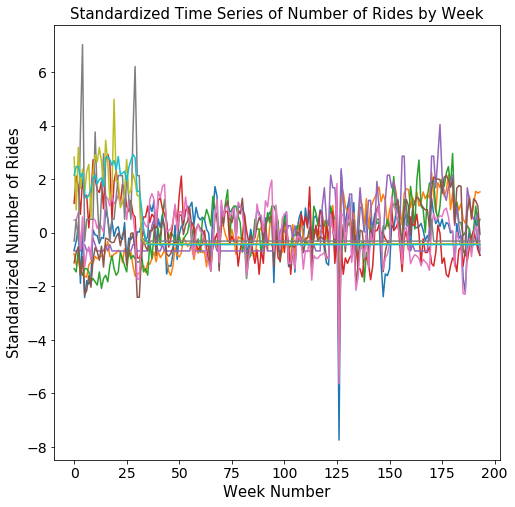

In [33]:
# plot the time series
fig = plt.figure(figsize=(8,8))
for i in range(10):
    pl.plot(standardizedts[i])
pl.title("Standardized Time Series of Number of Rides by Week", fontsize=15)
pl.xlabel("Week Number", fontsize=15)
pl.ylabel("Standardized Number of Rides", fontsize=15)

**Figure 3**: Standardized time series showing number of rides per week by station. The large dip corresponds to Hurricane Sandy which we identified earlier as an event with > 3 sigma drop. The MTA closed subways during Sandy which is why we see this large dip in rides. 

## fit a line to each time series (get slope and y intercept)

In [34]:
# fit a line to the data 
# don't use standardized time series 

# create an empty array for all the fits 
allfits = []

# create a model for each time series in tots 
for i in range(len(tots)):
    model = smf.ols('y ~ x + 1', data={'y':tots[i],'x':np.array(range(len(tots[i])))}).fit()
    allfits.append(model)
    
[(a.params[0]) for a in allfits[:10]]

[3545.2318794607445,
 81.160348929421076,
 9.2390166534496423,
 40.726566217287861,
 -1.4374306106264856,
 1477.2713719270421,
 1363.03425852498,
 1.3029341792228388,
 16.241554321966689,
 104.16367961934969]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [35]:
# remove labels from time series with nans
labels = labels[mta_flat]
len(labels)

7660

## Build and test a random forest model that predicts the ticket type based on 4 engineered features

In [36]:
# split into training and test sets using sklearn 
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              normed_time_series_mean, normed_time_series_std]).T, labels, test_size=0.33, random_state=42)

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [37]:
# check for infinities --> there are none 
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

In [38]:
# create random forest classifier 
clf = rfc(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
# fit random forest classifier
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
# predict y using the RF classifier 
y_pred = clf.predict(X_test)
print("Classifier score:", clf.score(X_test, y_test))

Classifier score: 0.736550632911


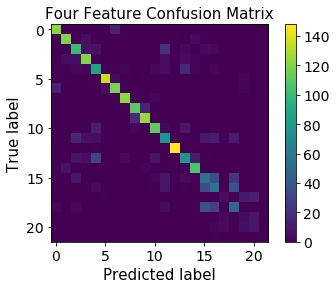

In [40]:
# use sklearn confusion_matrix to see the errors
plt.imshow(confusion_matrix(y_test, y_pred))
plt.title("Four Feature Confusion Matrix", fontsize=15)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.colorbar()

**Figure 4**: Confusion matrix for RF model with four feature engineered features. The confusion matrix evaluates the quality of the random forest classifier. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions. Yellows and greens indicate a high number of points correctly predicted. The confusion matrix is yellow and green along the diagonal for stations 0 through 14 indicating that the model predicted these stations well. The model did not predict stations 14 to 20 as well which is indicated by darker blues and purples along the diagonal for those stations. 

In [41]:
# use classification_report to assess the model 
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.88      0.90      0.89       135
        14d       0.89      0.90      0.90       133
         1d       0.69      0.68      0.69       148
         2t       0.81      0.82      0.82       147
        30d       0.58      0.69      0.63       124
         7d       0.94      0.94      0.94       144
        ada       0.87      0.84      0.85       142
       afas       0.95      0.98      0.96       126
        exp       0.84      0.88      0.86       125
         ez       0.88      0.87      0.88       143
         ff       0.85      0.82      0.84       137
         mc       0.59      0.57      0.58       138
         mr       0.99      0.99      0.99       149
      month       0.65      0.53      0.58       146
        rfm       0.84      0.90      0.87       119
         rr       0.38      0.39      0.39       138
        sen       0.40      0.40      0.40       142
       spec       0.38      0.17      0.24   

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Discussion**: The classification report reports on precision, recall, fl-score, and support for the random forest classifier for each of the card types. Precision is the number of true positives divided by the total number of elements labeled as belonging to the positive class. Recall is the number of true positives divided by the total number of elements that actually belong to the positive class. Precision and recall are the same (0.73) because we know what all of the labels are. A precision of 0.73 indicates that the model classified 73% true positives. 

In [42]:
# use clf.feature_importances_ to find the important features
X_train_df = pd.DataFrame(X_train)
X_train_df.columns = ("Slope", "Intercept", "Normed Mean", "Normed Standard Deviation")
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train_df.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

                           importance
Normed Mean                  0.333444
Normed Standard Deviation    0.257615
Intercept                    0.227656
Slope                        0.181285


**Discussion**: In the four feature model, normed mean is the most important feature followed by intercept, normed standard deviation, and slope. 

## Build a model that uses as input features each time stamp (194 features)


In [43]:
# use the same split ratio
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(tots, labels, 
                                            test_size=0.33, random_state=42)

In [44]:
# create random forest classifier 
clf_full = rfc(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
# fit random forest classifier
clf_full.fit(X_train_full, y_train_full)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
# predict y using the RF classifier 
y_pred_full = clf_full.predict(X_test_full)

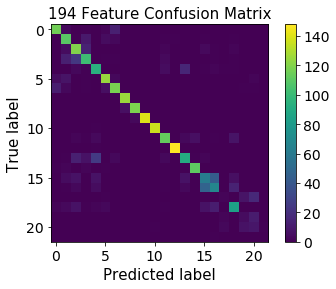

In [46]:
# use sklearn confusion_matrix to see the errors
imshow(confusion_matrix(y_test_full, y_pred_full))
plt.title("194 Feature Confusion Matrix", fontsize=15)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.colorbar()

**Figure 5**: Confusion matrix for RF model with all 194 timestamp features. The confusion matrix evaluates the quality of the random forest classifier. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions. Yellows and greens indicate a high number of points correctly predicted. This confusion matrix is more yellow and green along the diagonal than the confusion matrix for the four feature model, indicating that the 194 feature model did a better job of classifying the data. 

In [47]:
# use classification_report to assess the model 
print(classification_report(y_test_full, y_pred_full, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.85      0.86      0.86       135
        14d       0.71      0.83      0.76       133
         1d       0.67      0.81      0.73       148
         2t       0.72      0.69      0.71       147
        30d       0.68      0.76      0.71       124
         7d       0.87      0.87      0.87       144
        ada       0.84      0.83      0.83       142
       afas       0.95      1.00      0.98       126
        exp       0.98      0.95      0.96       125
         ez       1.00      0.98      0.99       143
         ff       0.99      0.99      0.99       137
         mc       0.86      0.82      0.84       138
         mr       0.99      0.99      0.99       149
      month       0.75      0.62      0.68       146
        rfm       0.94      0.93      0.94       119
         rr       0.50      0.45      0.47       138
        sen       0.53      0.48      0.50       142
       spec       0.25      0.07      0.11   

**Discussion**: The classification report reports on precision, recall, fl-score, and support for the random forest classifier for each of the card types. Precision is the number of true positives divided by the total number of elements labeled as belonging to the positive class. Recall is the number of true positives divided by the total number of elements that actually belong to the positive class. Precision and recall improved from 0.73 in the four feature model to 0.79 and 0.78 respectively, indicating that the 194 feature model did a better job of classifying than the four features model. The 194 feature model predicted 79% true positives. 

In [48]:
# use clf.feature_importances_ to find the important features
clf_full_imp = np.sort(clf_full.feature_importances_) 
top = clf_full_imp[-1]
second = clf_full_imp[-2]
print(dates[np.where(clf_full_imp == top)])
print(dates[np.where(clf_full_imp == second)])

DatetimeIndex(['2014-02-02'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2014-01-26'], dtype='datetime64[ns]', freq=None)


**Discussion** The most important timestamps for the 194 feature model are 2/2/2014 and 1/26/2014. 

**Overall Discussion**: Overall, the random forest model that uses all 194 timestamps is a better classifier of the data than the random forest model that uses only 4 feature engineered features. However, the 194 feature model is not that much better (precision went from 73% to 79%). It's more computationally intensive to use the 194 feature model. 